In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import scipy
from scipy.sparse.linalg import svds

In [2]:
data = pd.read_csv("mirnas_all_nov21.txt", sep="\t")
labels = pd.read_csv("mirnas_all_labels_nov21.txt", sep="\t")

data=data.drop(['Unnamed: 0'], axis=1)
data.set_index('ID_REF')
data.head()

,ID_REF,GSM279964,GSM279974,GSM279975,GSM279977,GSM279978,GSM279958,GSM279961,GSM279963,GSM279965,...,GSM237966,GSM237967,GSM237968,GSM237969,GSM237970,GSM237972,GSM237973,GSM237974,GSM237977,GSM237978
0,1007_s_at,10.022909,9.818693,9.647424,9.841938,9.190691,10.214065,10.284017,7.008211,9.145673,...,3739.4300,2809.7200,2350.390,4079.3500,7302.00000,2898.6400,3494.1600,5225.7500,5917.5400,4249.9400
1,1053_at,6.411660,5.665370,5.613482,5.190008,5.180046,6.396298,6.048790,5.671556,5.624627,...,1205.6400,883.9270,1418.130,721.6150,641.33900,1009.4900,788.6240,1227.7000,662.1490,1315.5500
2,117_at,6.181633,5.700626,5.786576,5.237599,6.131352,7.620443,6.481317,5.739559,6.072929,...,89.1387,81.6689,366.327,151.8190,191.91400,134.4140,67.0623,104.0020,15.1112,119.9420
3,121_at,7.436633,7.053211,7.258615,7.562595,7.330315,7.364233,7.421833,7.620457,7.507055,...,787.3290,848.5340,1454.480,1142.3000,1099.31000,762.8810,408.8580,684.3200,612.0700,809.6950
4,1255_g_at,2.887094,3.000947,3.121344,3.086248,3.480671,2.905494,2.968376,3.221801,3.069448,...,80.9794,30.6078,103.337,36.9773,5.61104,92.5094,30.6197,17.8383,11.1367,93.9161


In [3]:
# turn dataset into numpy array; will need these to recreate data frame later
data_heading=data.columns
id_refs=data['ID_REF']

np_data = np.array(data)[:,1:].astype(float)
np_data.shape

(54675, 1494)

In [4]:
# get labels into numpy array
sample_labels=labels['Sample_label'].values

sample_labels = ['Normal' if x=='Metastasis Normal' or x=='Primary Normal' else x for x in labels['Sample_label'].values]
sample_labels=np.asarray(sample_labels)

np.unique(sample_labels,return_counts=True)

(array(['Metastasis Tumor', 'Normal', 'Primary Tumor'], dtype='<U16'),
 array([ 243,   75, 1176], dtype=int64))

# Dimensionality Reduction using PCA

In [5]:
# tiffany's PCA, uses SVD
def PCA(PCA_K, input_data):

    total_dim, sample_n = input_data.shape

    data_mean = np.reshape(np.mean(input_data, axis=1),(total_dim,1))
    data_demean = np.subtract(input_data, data_mean)

    u, s, vt = svds(data_demean, k=PCA_K)

    PCA_weights = np.matmul(np.transpose(u), data_demean)
    
    return PCA_weights, u, s, data_mean


In [6]:
num_dims = 500
weights, u, s, mean = PCA(num_dims, np_data)

In [7]:
# Adjust number of features used here
num_features = 45
pca_data = np.matmul(np.transpose(u[:,num_dims - num_features:]), np.subtract(np_data,mean))

# Test Train Split

In [8]:
# train test split 
np.random.seed(69)
ii = np.random.rand(len(pca_data[0])) < 0.7 

train = pca_data[:,ii]
test = pca_data[:,~ii]

train_labels = sample_labels[ii]
test_labels = sample_labels[~ii]

gsms=data.columns[1:]
train_gsm = gsms[ii]
test_gsm=gsms[~ii]

In [9]:
uniqs, counts = np.unique(train_labels, return_counts=True)
print(counts)
print(train.shape)
print(gsms.shape)

[168  50 831]
(45, 1049)
(1494,)


# Training Model and Prediction

In [10]:
def compute_confusion_matrix(true, pred):
    '''
    Compute a confusion matrix using numpy for two np.arrays
    true and pred.

    Results are identical (and similar in computation time) to: 
    "from sklearn.metrics import confusion_matrix"

    https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    '''
    # lol map of indicies for non-numeric classes
    count=0
    idx={}
    for i in np.unique(true):
        idx[i]=count
        count+=1
        
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[idx[true[i]]][idx[pred[i]]] += 1
        
    print("Accuracy: " + str(np.trace(result)/len(true)))

    return result

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score

C_reg = 0.1
class_w = 'balanced'
solver = 'newton-cg'
max_iter = 2000
# logreg_multinomial = LogisticRegression(C=C_reg, class_weight=class_w, solver=solver, multi_class='multinomial', max_iter=max_iter).fit(train.T, train_labels)
logreg_ovr = LogisticRegression(C=C_reg, class_weight=class_w, solver=solver, multi_class='ovr', max_iter=max_iter).fit(train.T, train_labels)

C:\Users\wl439\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wl439\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wl439\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wl439\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wl439\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

In [12]:
# logpred_multinomial = logreg_multinomial.predict(test.T)
logpred_ovr = logreg_ovr.predict(test.T)

y_true = pd.Series(test_labels)
# y_multinomial_pred = pd.Series(logpred_multinomial)
y_ovr_pred = pd.Series(logpred_ovr)

In [73]:
# print("Multinomial Logistics Regression Confusion Matrix:")
# cm_multinomial = compute_confusion_matrix(test_labels, y_multinomial_pred)
# kappa_multi = cohen_kappa_score(test_labels, y_multinomial_pred)
# print("kappa: ")
# print(kappa_multi)
# pd.crosstab(y_true, y_multinomial_pred, rownames=['True'], colnames=['Predicted'], margins=True)


In [13]:
print("One-over-all Logistics Regression Confusion Matrix:")
cm_ovr = compute_confusion_matrix(test_labels, y_ovr_pred)
kappa_ovr = cohen_kappa_score(test_labels, y_ovr_pred)
print("kappa: ")
print(kappa_ovr)
pd.crosstab(y_true, y_ovr_pred, rownames=['True'], colnames=['Predicted'], margins=True)


One-over-all Logistics Regression Confusion Matrix:
Accuracy: 0.8179775280898877
kappa: 
0.5925737538148526


Predicted,Metastasis Tumor,Normal,Primary Tumor,All
True,,,,
Metastasis Tumor,64,2,9,75
Normal,5,20,0,25
Primary Tumor,50,15,280,345
All,119,37,289,445


In [22]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, show=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    f = plt.figure()

    plt.imshow(cm, interpolation='nearest', cmap='viridis')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                horizontalalignment="center",
                color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

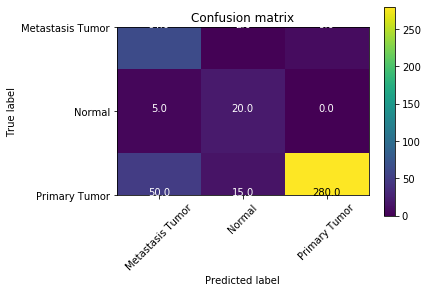

In [24]:
plot_confusion_matrix(cm_ovr, ['Metastasis Tumor', 'Normal', 'Primary Tumor'])

### After playing around with the parameters and number of features, using 45 features in a one-over-all logistics regression model with a newton optimization method with 2000 max iterations gives the best performance. Note that the classes need to be weighted to balance the imbalanced distribution. 

### All classes can be predicted fairly balancedly, with around 80% accuracy